# A Demo and Comparison of Categorical Methods

**Feature engineering is a critical component of creating any machine learning model from a dataset, yet it is arguably one of the most manually intensive steps in the ML process. One of the biggest contributors to this is handling non-numeric data--categorical encoding is an essential part of nearly every dataset, but often comes with its own challenges.**

In this notebook, we will be demonstrating the use of Featuretools' categorical-encoding on datasets. Specifically, we will compare and contrast the performance of several different categorical methods. For a detailed guide on the when/how of using categorical methods, check out [this comprehensive notebook](https://github.com/FeatureLabs/categorical-encoding/blob/master/notebooks/categorical-encoding-guide.ipynb).

For this demo, we will be using the Instacart dataset located on [Kaggle](https://www.kaggle.com/c/instacart-market-basket-analysis/data). For the purposes of this demo, we will not be detailing every single step involved in the machine learning problem. For that, check out [this comprehensive demo](https://github.com/Featuretools/predict-next-purchase) by Feature Labs, Inc.

If you are planning to follow this tutorial yourself, please refer to [this link](https://github.com/Featuretools/predict-next-purchase#running-the-tutorial) for instructions to download/prepare the data. 

In [1]:
import featuretools as ft
import pandas as pd
import utils1 as utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os
import categorical_encoding as ce

## Load EntitySet

We will load only one partition of our data, which still contains all the relevant information to the users contained in the partition.

In [2]:
es = utils.load_entityset("partitioned_data/part_1/")
es

Entityset: instacart
  Entities:
    order_products [Rows: 156605, Columns: 7]
    orders [Rows: 16328, Columns: 3]
    users [Rows: 1000, Columns: 2]
  Relationships:
    order_products.order_id -> orders.order_id
    orders.user_id -> users.user_id

## Explanation of Data/Problem

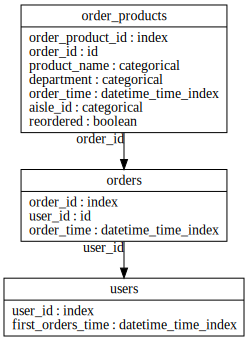

In [3]:
es.plot()

In this dataset, we're given information about each user, their specific orders, and the purchased products themselves. We can see that there are two categoricals that we must account for: `product_name` and `department`.

In this demo, we will predict whether or not a user will purchase a banana in the next 4 weeks.

In [4]:
label_times = utils.make_labels(es=es,
                                product_name = "Banana",
                                cutoff_time = pd.Timestamp('March 15, 2015'),
                                prediction_window = ft.Timedelta("4 weeks"),
                                training_window = ft.Timedelta("60 days"))
label_times.head(5)

,user_id,time,label
0,1001,2015-03-15,False
1,1002,2015-03-15,False
2,1003,2015-03-15,False
3,1004,2015-03-15,False
4,1005,2015-03-15,False


## Automated Feature Engineering with Featuretools DFS

In [5]:
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"), # same as above
                                  entityset=es,
                                  verbose=True)
feature_matrix.head()

Built 78 features
Elapsed: 00:09 | Progress: 100%|██████████


,COUNT(orders),COUNT(order_products),PERCENT_TRUE(order_products.reordered),NUM_UNIQUE(order_products.product_name),NUM_UNIQUE(order_products.department),NUM_UNIQUE(order_products.aisle_id),MODE(order_products.product_name),MODE(order_products.department),MODE(order_products.aisle_id),DAY(first_orders_time),...,COUNT(order_products WHERE department = frozen),COUNT(order_products WHERE product_name = Organic Hass Avocado),COUNT(order_products WHERE department = snacks),COUNT(order_products WHERE department = produce),COUNT(order_products WHERE department = bakery),COUNT(order_products WHERE product_name = Strawberries),COUNT(order_products WHERE product_name = Organic Whole Milk),NUM_UNIQUE(order_products.orders.user_id),MODE(order_products.orders.user_id),label
user_id,,,,,,,,,,,,,,,,,,,,,
1001,2,33,0.424242,26,11,20,Animal Crackers,snacks,78,1,...,2.0,0.0,9.0,1.0,2.0,0.0,0.0,1,1001,False
1002,5,49,0.244898,40,8,16,Chocolate Bars Minis Mix Variety Pack,snacks,45,1,...,0.0,0.0,25.0,1.0,0.0,0.0,0.0,1,1002,False
1003,6,79,0.670886,41,12,26,Fat Free Milk,dairy eggs,120,1,...,4.0,0.0,6.0,9.0,3.0,0.0,0.0,1,1003,False
1004,8,169,0.692308,76,11,19,Organic Granny Smith Apple,produce,83,1,...,4.0,0.0,1.0,126.0,7.0,0.0,0.0,1,1004,False
1005,5,54,0.518519,38,12,28,Blueberry Waffles,dairy eggs,24,1,...,5.0,0.0,6.0,6.0,0.0,0.0,0.0,1,1005,False


We notice that we still have several columns containing categorical values. Before we can input this matrix into our machine learning algorithm, we must first apply categorical encoding to these values.

## Categorical Encoding

We first examine the categorical data to get a better sense of what we're dealing with.

In [6]:
feature_matrix['MODE(order_products.product_name)'].describe()

count        782
unique       544
top       Banana
freq          46
Name: MODE(order_products.product_name), dtype: object

`product_name` still has 544 unique values, meaning we have a dataset with high cardinality.

### Categorical Encoding

In [7]:
encoder = ce.Encoder(method='ordinal')
fm_encoded = encoder.fit_transform(feature_matrix.drop(['label'], axis=1), features)
fm_encoded['label'] = feature_matrix['label']
fm_encoded.head()

,COUNT(orders),COUNT(order_products),PERCENT_TRUE(order_products.reordered),NUM_UNIQUE(order_products.product_name),NUM_UNIQUE(order_products.department),NUM_UNIQUE(order_products.aisle_id),MODE(ORDER_PRODUCTS.PRODUCT_NAME)_ordinal,MODE(ORDER_PRODUCTS.DEPARTMENT)_ordinal,MODE(order_products.aisle_id),DAY(first_orders_time),...,COUNT(order_products WHERE department = frozen),COUNT(order_products WHERE product_name = Organic Hass Avocado),COUNT(order_products WHERE department = snacks),COUNT(order_products WHERE department = produce),COUNT(order_products WHERE department = bakery),COUNT(order_products WHERE product_name = Strawberries),COUNT(order_products WHERE product_name = Organic Whole Milk),NUM_UNIQUE(order_products.orders.user_id),MODE(order_products.orders.user_id),label
user_id,,,,,,,,,,,,,,,,,,,,,
1001,2,33,0.424242,26,11,20,1,1,78,1,...,2.0,0.0,9.0,1.0,2.0,0.0,0.0,1,1001,False
1002,5,49,0.244898,40,8,16,2,1,45,1,...,0.0,0.0,25.0,1.0,0.0,0.0,0.0,1,1002,False
1003,6,79,0.670886,41,12,26,3,2,120,1,...,4.0,0.0,6.0,9.0,3.0,0.0,0.0,1,1003,False
1004,8,169,0.692308,76,11,19,4,3,83,1,...,4.0,0.0,1.0,126.0,7.0,0.0,0.0,1,1004,False
1005,5,54,0.518519,38,12,28,5,2,24,1,...,5.0,0.0,6.0,6.0,0.0,0.0,0.0,1,1005,False


All columns are now properly in a numeric format and are prepared for a machine learning algorithm.

## Machine Learning

We will continue with this smaller partition and train a Random Forest Classifier with 3-fold cross-validation on it.

In [8]:
utils.machine_learning_score(fm_encoded, label_times)

'AUC 0.83 +/- 0.02'

We notice that we scored pretty high relative to guessing! We will now compare all the encoding methods.

## Comparing Categorical Encoding Methods

For this section, we will be using the [categorical-encoding](https://pypi.org/project/categorical-encoding/) library.

In [9]:
results = utils.encoder_results(feature_matrix, features, label_times)
results

,Encoder,Score,# Columns,Elapsed Time
0,ordinal,AUC 0.84 +/- 0.02,79,1.700674
1,one_hot,AUC 0.84 +/- 0.02,135,1.827049
2,binary,AUC 0.83 +/- 0.03,108,2.051645
3,hashing,AUC 0.83 +/- 0.01,107,7.593556
4,target,AUC 0.87 +/- 0.00,78,2.957184
5,leave_one_out,AUC 0.87 +/- 0.01,78,2.640933
6,no_categoricals,AUC 0.84 +/- 0.02,74,4.709374


The biggest differences lie in the columns created and the elapsed time: bayesian encoders such as `target` and `leave_one_out` perform better than the other encoders while retaining similar times.

One-hot encoding produces the most columns, as expected--it's interesting to note that hashing takes longer than one_hot despite having less columns. This marks a tradeoff between memory, accuracy, and efficiency when picking hashing encoding over alternatives.

However, for this particular problem, we can see that the categorical values don't seem to affect the model accuracy much--there is little difference from our control `no categoricals`, which is a feature_matrix with all categorical-data removed.